In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.ensemble import StackingRegressor

In [2]:
# Reading the Data
df =  pd.read_csv('house_prices.csv',encoding='gbk',low_memory=False)#, errors='ignore')
# Shape of the Data
print ('DATA',df.shape)
df.head(5)

DATA (318851, 26)


,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.019520,1111027376244,2016-08-09,1464.0,106,415.0,31680,...,1.0,2005,3,6,0.217,1.0,0.0,1.0,7,56021.0
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1111027381879,2016-07-28,903.0,126,575.0,43436,...,1.0,2004,4,6,0.667,1.0,1.0,0.0,7,71539.0
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1111040862969,2016-12-11,1271.0,48,1030.0,52021,...,4.0,2005,3,6,0.500,1.0,0.0,0.0,7,48160.0
3,https://bj.lianjia.com/chengjiao/101086406841....,101086406841,116.438010,40.076114,1111043185817,2016-09-30,965.0,138,297.5,22202,...,1.0,2008,1,6,0.273,1.0,0.0,0.0,6,51238.0
4,https://bj.lianjia.com/chengjiao/101086920653....,101086920653,116.428392,39.886229,1111027381174,2016-08-28,927.0,286,392.0,48396,...,4.0,1960,2,2,0.333,0.0,1.0,1.0,1,62588.0


In [3]:
# Columns or Features or Variables
df.columns

Index(['url', 'id', 'Lng', 'Lat', 'Cid', 'tradeTime', 'DOM', 'followers',
       'totalPrice', 'price', 'square', 'livingRoom', 'drawingRoom', 'kitchen',
       'bathRoom', 'floor', 'buildingType', 'constructionTime',
       'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator',
       'fiveYearsProperty', 'subway', 'district', 'communityAverage'],
      dtype='object')

In [4]:
# Finding missing Values in each column or feature
df.isnull().sum()

url                         0
id                          0
Lng                         0
Lat                         0
Cid                         0
tradeTime                   0
DOM                    157977
followers                   0
totalPrice                  0
price                       0
square                      0
livingRoom                  0
drawingRoom                 0
kitchen                     0
bathRoom                    0
floor                       0
buildingType             2021
constructionTime            0
renovationCondition         0
buildingStructure           0
ladderRatio                 0
elevator                   32
fiveYearsProperty          32
subway                     32
district                    0
communityAverage          463
dtype: int64

In [5]:
df = df[df['constructionTime']!='未知']
X = df[['followers', 'constructionTime']]  # Predictor variables
y = df['DOM']  # Target variable

# Drop rows where 'DOM' is missing
X = X[y.notnull()]
y = y[y.notnull()]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor

# Initialize the model
model = RandomForestRegressor(random_state=42)

# Fit the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R-squared: {r2}')

# Isolate the rows where 'DOM' is missing and the predictors are not missing
X_missing = df.loc[df['DOM'].isnull() & df[['followers', 'constructionTime']].notnull().all(axis=1), ['followers', 'constructionTime']]

# Predict the 'DOM' using the model
predicted_DOM = model.predict(X_missing)

# Fill in the missing 'DOM' values in the original DataFrame
df.loc[df['DOM'].isnull(), 'DOM'] = predicted_DOM

MAE: 25.080222455666036
MSE: 2148.2762058534004
R-squared: 0.19351571296106795


In [6]:
# Step 1: Remove variables with more than 50% missing data
#df = df.drop(['DOM'], axis=1)
# Step 2: Remove observations with any missing values
df = df.dropna()
# Step 3: Removing the columns 'kitchens', 'bathrooms', and 'drawingRooms'
df.drop(['kitchen', 'bathRoom', 'drawingRoom', 'url', 'id', 'Cid', 'floor', 'buildingType', 'ladderRatio'], axis=1, inplace=True)
# Step 4: Setting the number of living rooms to be within the range of 1 to 4
df['livingRoom'] = pd.to_numeric(df['livingRoom'], errors='coerce')
df['livingRoom'] = df['livingRoom'].clip(lower=1, upper=4)
df.columns
print ("DATA", df.shape)

DATA (297701, 17)


In [7]:
# Creating 'distance' feature
# To calculate Distance Between Two Points on Earth 
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2=39.916668, lon2=116.383331):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

df['distance'] = df.apply(lambda x: haversine(x['Lat'], x['Lng']), axis=1)
df['constructionTime'] = df['constructionTime'].astype(int)
df['age'] = 2023 - pd.to_numeric(df['constructionTime'], errors='coerce')
# Drop the original 'constructionTime' column
df.drop('constructionTime', axis=1, inplace=True)

# Set minimum values
min_price = 10000
min_square = 20

df['price'] = df['price'].clip(lower=min_price)
df['square'] = df['square'].clip(lower=min_square)

print ('DATA',df.shape)
df.head(1)

DATA (297701, 18)


,Lng,Lat,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,renovationCondition,buildingStructure,elevator,fiveYearsProperty,subway,district,communityAverage,distance,age
0,116.475489,40.01952,2016-08-09,1464.0,106,415.0,31680,131.0,2,3,6,1.0,0.0,1.0,7,56021.0,13.873607,18


In [8]:
# 'timeTrade' feature to year base only.
df['tradeTime'] = pd.DatetimeIndex(df['tradeTime']).year

# Converting features datatype to see outliers
df['livingRoom'] = df['livingRoom'].astype(int)
df['tradeTime'] = df['tradeTime'].astype(int)
df['DOM'] = df['DOM'].astype(int)
df['renovationCondition'] = df['renovationCondition'].astype(int)
df['buildingStructure'] = df['buildingStructure'].astype(int)
df['elevator'] = df['elevator'].astype(int)
df['fiveYearsProperty'] = df['fiveYearsProperty'].astype(int)
df['subway'] = df['subway'].astype(int)
df['followers']  = df['followers'].astype(int)
df['totalPrice']  = df['totalPrice'].astype(int)
df['elevator']  = df['elevator'].astype(int)
df['fiveYearsProperty']  = df['fiveYearsProperty'].astype(int)
df['subway']  = df['subway'].astype(int)
df['age']  = df['age'].astype(int)

# Reseting the index
df.reset_index(inplace=True)
df.drop(['index'],axis=1,inplace=True)
# Now the remaining data
print ("DATA", df.shape)
df.head()

print ( "The DATA" , df.shape)
df.dtypes

DATA (297701, 18)
The DATA (297701, 18)


Lng                    float64
Lat                    float64
tradeTime                int32
DOM                      int32
followers                int32
totalPrice               int32
price                    int64
square                 float64
livingRoom               int32
renovationCondition      int32
buildingStructure        int32
elevator                 int32
fiveYearsProperty        int32
subway                   int32
district                 int64
communityAverage       float64
distance               float64
age                      int32
dtype: object

In [9]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

# Fit the model
iso_forest.fit(df[['price']])

# Predict anomalies (1 for normal, -1 for anomaly)
outliers = iso_forest.predict(df[['price']])

# Add a column to your DataFrame to indicate outliers
df['outlier'] = outliers

# Filter out the outliers
df_clean = df[df['outlier'] == 1]

# Display the shape of the original and cleaned dataframes
print("Original DataFrame shape:", df.shape)
print("DataFrame without outliers shape:", df_clean.shape)

Original DataFrame shape: (297701, 19)
DataFrame without outliers shape: (294759, 19)


In [10]:
# Selecting features and target variable
X = df_clean[['tradeTime', 'DOM', 'followers', 'square', 'livingRoom',
       'renovationCondition', 'buildingStructure',
       'elevator', 'fiveYearsProperty', 'subway', 'district',
       'communityAverage', 'distance', 'age']]

# Standardized the Features
X = np.asarray(X)
X = preprocessing.StandardScaler().fit(X).transform(X)  

# Selecting Target Feature
y = df_clean['price']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Initialize the XGBoost
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', min_child_weight = 2, subsample = 1,
                          colsample_bytree = 0.8,
                          learning_rate = 0.2, n_estimators = 500,
                         reg_lambda = 0.45, reg_alpha = 0, gamma = 0.5)

# Train the model
xg_reg.fit(X_train,y_train)

# Making predictions
y_pred = xg_reg.predict(X_test)

# Evaluating the model
print ("RMSLE {:,.5f}".format(np.sqrt(mean_squared_log_error( y_pred, y_test))))

RMSLE 0.13547


In [12]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error

space = {
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'gamma': hp.uniform('gamma', 0, 1)
}
def objective(space):
    model = xgb.XGBRegressor(min_child_weight=int(space['min_child_weight']),
                            subsample=space['subsample'],
                            colsample_bytree=space['colsample_bytree'],
                            learning_rate=space['learning_rate'],
                            n_estimators=int(space['n_estimators']),
                            reg_lambda=space['reg_lambda'],
                            reg_alpha=space['reg_alpha'],
                            gamma=space['gamma'])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    loss = mean_squared_error(y_test, y_pred)
    return {'loss': loss, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|██████████| 100/100 [05:42<00:00,  3.42s/trial, best loss: 31538936.072436783]


In [13]:
from hyperopt import space_eval

best_parameters = space_eval(space, best)
print("Best Parameters:", best_parameters)

Best Parameters: {'colsample_bytree': 0.9685647459869511, 'gamma': 0.25150083611652824, 'learning_rate': 0.15682762805689904, 'min_child_weight': 3.0, 'n_estimators': 964, 'reg_alpha': 0.0794086208565698, 'reg_lambda': 0.5083039666810512, 'subsample': 0.8507974083684748}


In [14]:
# Initialize the XGBoost

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          min_child_weight = best_parameters['min_child_weight'], 
                          subsample = best_parameters['subsample'],
                          colsample_bytree = best_parameters['colsample_bytree'],
                          learning_rate = best_parameters['learning_rate'], 
                          n_estimators = best_parameters['n_estimators'],
                          reg_lambda = best_parameters['reg_lambda'], 
                          reg_alpha = best_parameters['reg_alpha'], 
                          gamma = best_parameters['gamma'])

# Train the model
xg_reg.fit(X_train,y_train)

# Making predictions
y_pred = xg_reg.predict(X_test)

# Evaluating the model
print ("RMSLE {:,.5f}".format(np.sqrt(mean_squared_log_error( y_pred, y_test))))

RMSLE 0.13369


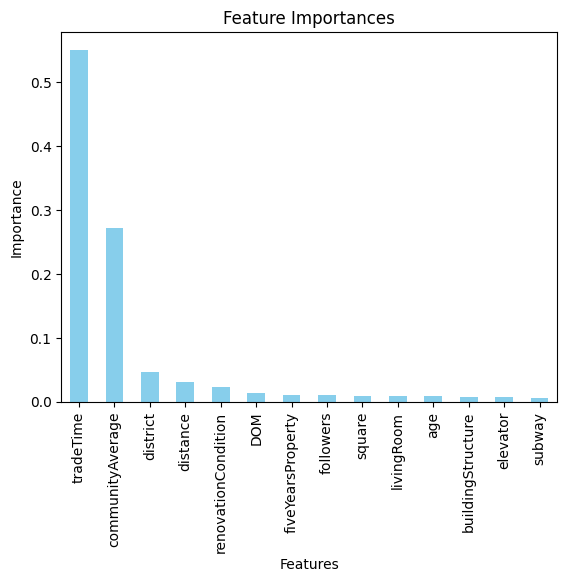

In [16]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = xg_reg.feature_importances_

feature_names = ['tradeTime', 'DOM', 'followers', 'square', 'livingRoom',
       'renovationCondition', 'buildingStructure',
       'elevator', 'fiveYearsProperty', 'subway', 'district',
       'communityAverage', 'distance', 'age']
importances_series = pd.Series(feature_importances, index=feature_names)

# Sort the features by importance
importances_series = importances_series.sort_values(ascending=False)

# Plot
importances_series.plot(kind='bar', color='skyblue')
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [17]:
from sklearn.feature_selection import RFE

# Initialize the XGBoost
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          min_child_weight = best_parameters['min_child_weight'], 
                          subsample = best_parameters['subsample'],
                          colsample_bytree = best_parameters['colsample_bytree'],
                          learning_rate = best_parameters['learning_rate'], 
                          n_estimators = best_parameters['n_estimators'],
                          reg_lambda = best_parameters['reg_lambda'], 
                          reg_alpha = best_parameters['reg_alpha'], 
                          gamma = best_parameters['gamma'])

# Initialize RFE with the XGBoost model and desired number of features
num_features_to_select = 10  # Adjust this to the number of features you want
rfe = RFE(estimator=xg_reg, n_features_to_select=num_features_to_select)

# Fit RFE
rfe.fit(X_train, y_train)

# Transform training and testing sets
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# You can also retrieve the ranking of the features
ranking = rfe.ranking_

# Fit the model with the selected features for further modeling
xg_reg.fit(X_train_rfe, y_train)

# Now, xgb_reg can be used for predictions and further analysis
y_pred = xg_reg.predict(X_test_rfe)

# Evaluating the model
print ("RMSLE {:,.5f}".format(np.sqrt(mean_squared_log_error( y_pred, y_test))))

RMSLE 0.13784
